**Remark**:
The specific versions of the following libraries that were used when running this notebook are added in a `requirements.txt` file. Please note that the project is not guaranteed to work on versions that are higher/lower than those mentioned in the text file submitted with this notebook. 

You can install those packages by running `pip install -r requirements.txt`.

# Data Loading and Formatting

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import make_scorer, f1_score
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import randint
import random
from imblearn.over_sampling import SMOTE

We will start by loading the contents of `emotion.csv` file and taking a look at them.

In [2]:
emotion_df = pd.read_csv('CK+_lands/CK+/emotion.csv', sep=';')

emotion_df.head()

,subject,file,emotion
0,S005,1,5
1,S010,1,2
2,S010,2,3
3,S010,3,6
4,S010,4,4


The emotions dataframe contains 3 columns which are the subject, file (session number) and emotion which is the target.

Next, we will load the facial landmarks of the subjects in `landmarks_df`.

In [3]:
def load_facial_landmarks(subject):
    landmarks_df = pd.read_csv('CK+_lands/CK+/'+subject+'/omlands.csv', sep=';', header=None)
    landmarks_df['subject'] = subject
    landmarks_df.rename(columns={0: 'file'}, inplace=True)
    return landmarks_df

all_landmarks = []

for subject in emotion_df['subject'].unique():
    landmarks_df = load_facial_landmarks(subject)
    all_landmarks.append(landmarks_df)

landmarks_df = pd.concat(all_landmarks, ignore_index=True)
landmarks_df.head()

,file,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,subject
0,1,430,400,429,478,439,555,457,631,486,...,829,676,776,672,746,676,717,672,,S005
1,1,430,400,429,478,439,555,457,631,486,...,829,676,776,672,746,676,717,672,,S005
2,1,428,398,426,478,435,557,452,635,481,...,829,675,778,672,746,676,717,673,,S005
3,1,431,400,430,477,439,555,456,631,484,...,829,675,778,670,747,675,718,671,,S005
4,1,429,399,430,477,441,555,459,631,488,...,828,672,777,669,746,674,717,669,,S005


We notice that column 137 is empty. So, we will drop it.

In [4]:
landmarks_df.drop(columns=[137], inplace=True)
landmarks_df.head()

,file,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,subject
0,1,430,400,429,478,439,555,457,631,486,...,669,829,676,776,672,746,676,717,672,S005
1,1,430,400,429,478,439,555,457,631,486,...,669,829,676,776,672,746,676,717,672,S005
2,1,428,398,426,478,435,557,452,635,481,...,668,829,675,778,672,746,676,717,673,S005
3,1,431,400,430,477,439,555,456,631,484,...,667,829,675,778,670,747,675,718,671,S005
4,1,429,399,430,477,441,555,459,631,488,...,665,828,672,777,669,746,674,717,669,S005


# Descriptive and Statistical analysis of the Data

In [5]:
emotion_stats = emotion_df['emotion'].value_counts()

sessions_per_subject = emotion_df['subject'].value_counts()
images_per_subject = landmarks_df['subject'].value_counts()

emotion_stats_summary = emotion_stats.describe()
sessions_per_subject_summary = sessions_per_subject.describe()
images_per_subject_summary = images_per_subject.describe()

print("Emotion counts:\n", emotion_stats,  sep='')
print("\nEmotions statistics:\n", emotion_stats_summary, sep='')
print("\nSessions per subject statistics:\n", sessions_per_subject_summary, sep='')
print("\nImages per subject statistics:\n", images_per_subject_summary, sep='')

Emotion counts:
1    94
3    77
6    59
2    53
5    38
4    36
Name: emotion, dtype: int64

Emotions statistics:
count     6.000000
mean     59.500000
std      22.598673
min      36.000000
25%      41.750000
50%      56.000000
75%      72.500000
max      94.000000
Name: emotion, dtype: float64

Sessions per subject statistics:
count    99.000000
mean      3.606061
std       1.563736
min       1.000000
25%       2.000000
50%       4.000000
75%       5.000000
max       7.000000
Name: subject, dtype: float64

Images per subject statistics:
count     99.000000
mean      96.767677
std       37.003262
min       12.000000
25%       74.000000
50%       93.000000
75%      119.000000
max      220.000000
Name: subject, dtype: float64


From the preceding statistics, we can note the following:
<ol>
    <li>There are six different emotions with the following number of sessions per emotion:
        <ul>
            <li>happy: 94</li>
            <li>surprise: 77</li>
            <li>sadness: 59</li>
            <li>fear: 53</li>
            <li>disgust: 38</li>
            <li>anger: 36</li>
        </ul>
    </li>
    <li>The mean value of sessions per emotion is 59, and the standard deviation is 22.6</li>
    <li>The distribution of sessions among the different emotions is uneven with happiness having the highest number of sessions (94) and anger the lowest (36).</li>
    <li>This huge difference between the number of sessions can affect the models negatively. We can solve this issue by either oversampling or adjusting class weights.</li>
    <li>The average number of sessions that each subject recorded is 3.6 and the standard deviation is 1.5</li>
    <li>The minimum number of sessions that a subject recorded is 1, and the maximum is 7.</li>
    <li>This difference between the number of sessions per subject may cause the models to overfit to the subjects who recorded a higher number of sessions.</li>
    <li>The average of images per subject is 96.7. It is noteworthy that this number varies greatly as the minimum number of images per subject is 12 and the maximum is 220 which is way higher than 12. The standard deviation is 37.</li>
    <li>The huge difference between the number of images per subject means that some subjects have way more data than the others. This way, the model might be biased towards those subjects with more data.</li>
</ol>


# Visualization of Some Landmarks

Next, we will visualize some images in the dataset at their apex. This will help us notice how the landmarks vary with different emotions. To do this, we will first merge the 2 datasets and then choose randomly 1 image of each emotion at its apex.

In [6]:
emotions = ['happy', 'fear','surprise', 'anger', 'disgust', 'sadness']

def plot_facial_landmarks(row, ax):
    x = row.iloc[1:137:2]
    y = row.iloc[2:137:2]
    
    ax.scatter(x, y, s=10)
    ax.invert_yaxis()
    ax.set_title(f"Emotion: {emotions[row['emotion']-1]}")


def plot_apex_images_sample(dataframe):
    apex_images = dataframe.groupby(['subject', 'file']).tail(1)

    apex_sample_images = apex_images.groupby('emotion').apply(lambda x: x.sample(1)).reset_index(drop=True)

    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        plot_facial_landmarks(apex_sample_images.iloc[i], ax)

    plt.tight_layout()
    plt.show()

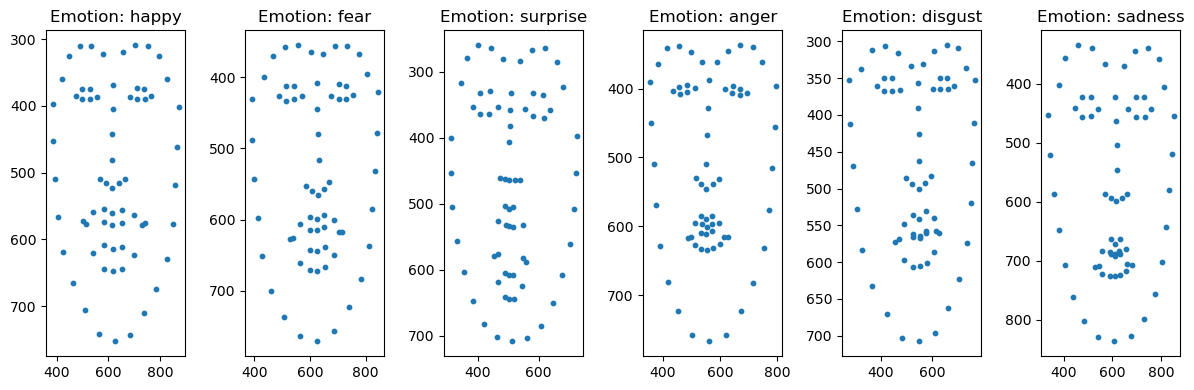

In [7]:
combined_df = pd.merge(landmarks_df, emotion_df, on=['subject', 'file'])
plot_apex_images_sample(combined_df)

From the preceding figures we can notice the following:
1. In the happiness emotion, the corners of the mouth are lifted.
2. In the fear emotion, the mouth is slightly opened.
3. In the surprised emotion, the mouth and eyes are widely opened and the eyebrows are raised.
4. In the anger emotion, the mouth is firmly closed and the brows are furrowed.
5. In the digust emotion, the eyes are a bit closed.
6. In the sadness emotion, the corners of the mouth are downturned.

As the faces are obviously not aligned, we will align them with respect to the eyes and nose. This can help mitigate variations due to head movements or different camera angles, which allows the models to focus more on the changes in facial expressions themselves. We will add the aligned faces to a new dataframe and perform training on the new aligned datasets.

To perform alignment, we will use the OpenCV library.

In [8]:
aligned_landmarks_list = []

def get_centroid(points):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    return (sum(x) / len(points), sum(y) / len(points))

def align_faces(landmarks):

    first_eye = landmarks[range(36, 42)]
    second_eye = landmarks[range(42, 48)]
    nose = landmarks[range(27, 36)]

    original_location = np.float32([get_centroid(first_eye), get_centroid(second_eye), get_centroid(nose)])
    desired_location = np.float32([(0.35, 0.35), (0.65, 0.35), (0.5, 0.6)])
    transformation_matrix = cv2.getAffineTransform(original_location, desired_location)

    aligned_landmarks = np.dot(transformation_matrix, np.vstack([landmarks.T, np.ones(len(landmarks))]))

    return aligned_landmarks.T

In [9]:
for index, row in landmarks_df.iterrows():
    landmarks = np.array(row[[i for i in range(1, 137)]]).reshape(-1, 2)
    aligned_landmarks = align_faces(landmarks)
    flattened_aligned_landmarks = aligned_landmarks.flatten()
    
    aligned_landmarks_list.append(flattened_aligned_landmarks)

In [10]:
aligned_coordinates_df = pd.DataFrame(aligned_landmarks_list, columns=[i for i in range(1, 137)])
aligned_landmarks_df = pd.concat([landmarks_df[['subject']].reset_index(drop=True), aligned_coordinates_df], axis=1)
aligned_landmarks_df = pd.concat([aligned_landmarks_df, landmarks_df[['file']].reset_index(drop=True)], axis=1)

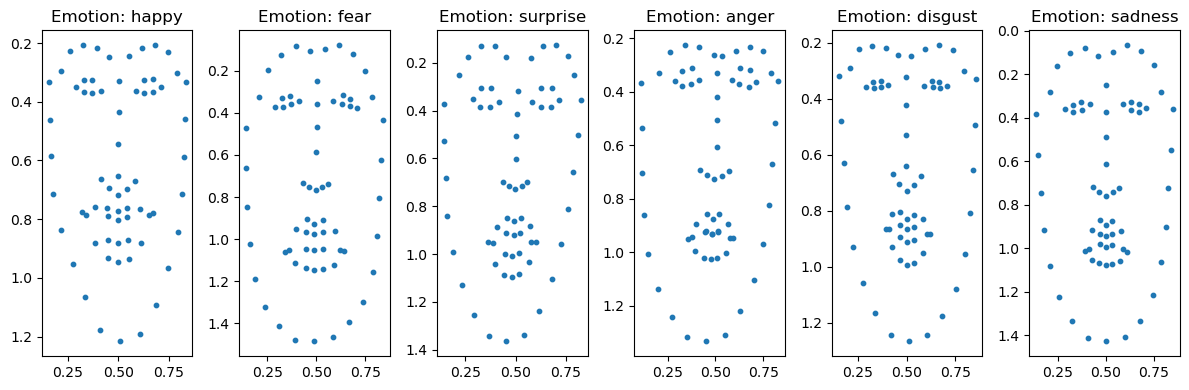

In [11]:
combined_df_aligned = pd.merge(aligned_landmarks_df, emotion_df, on=['subject', 'file'])

plot_apex_images_sample(combined_df_aligned)

# First Approaches

### I. Predict emotions using the coordinates of the points

First, we will split our dataset into training and testing sets. Then, we will train and apply several models and test them.

Since in the primary goal is to determine the emotion in the `emotion.csv` file which contains subjects and sessions along with their respective emotions, we must test the models on each session as a whole and not individual independent images.

**Method Adopted:** Train the model on the last 2 images in every session with their labels. This is because the first images in each session are either neutral or nearly neutral and have no meaning or effect whatsover on the emotion prediction. When testing the model, predict the emotion of the session by applying the model on the apex image of the session.

We will implement and test this approach. If it gave us disappointing results, other approaches will be adopted. If not, it means that the session's overall emotion can be detected by the apex image' emotion in that specific session.

*Since we are unaware of the relationship between the features of the data, we will use a combination of linear models and other more complex models and test them.*

The different models we will use are the following:
1. **Logistic Regression Classifier**: We will start off our training with this simple model as it can act as a baseline to estimate the performance before working on more complex models. This model is fast to train and easy to implement and explain.
2. **Stochastic Gradient Descent Classifer**: This classifier is a good choice in linearly separable data and can handle large datasets efficiently. If this model performed well, this indicates that the relationship between the feautures of the data was indeed linear to some extent.
3. **Ridge Classifier**: This is also a type of linear classifer. If our data can be well-separated or explained using linear boundaries, this classifier will perform well.
2. **Random Forest Classifier:** This is a more complex model. If the relationships between feautures is complex, this model will outperform the previously mentioned ones.
3. **Support Vector Machine Classifier**: With more than 136 attributes, our dataset is considered somehow a high dimensional dataset. SVM works well in such scenarios and is expected to produce good results in this classification problem.
4. **Neural Networks Classifier**: The classifier we will experiment with is the multilayer perceptron classifier (MLP). This model is a deeper neural network classifier and is designed to capture highly complex non-linear relationships between features of data thanks to its multiple layers and non-linear activation functions. As the relationship between landmarks and emotions is expected to be complicated and non-linear, the MLP classifier is considered a good choice here. 

## Application of the Adopted Method:

We will split the emotion dataframe into training and testing dataframes.

First, we will start by splitting our dataset and scaling it using standard scaler to prepare it for training. We will begin by using the default parameters of each model and later tune the hyperparameters and check whether any improvement is observed.

To split the dataset, the following steps will be taken:
1. Split the emotions dataframe into 80% training and 20% testing. This makes sure that we split the sessions and not the images in those sessions which might lead to mileading high accuracies because of data leakage.
2. Merge the resulting training and testing dataframes with the aligned landmarks dataframe on both the subject and the file (session number) to get the correct label for each image. Use only the last two images as the first images are neutral or nearly neutral.
3. When training the model, we will only take into account the coulmns corresponding to the coordinates. The subject and file number will not be taken into account as they have no meaning and no effect on the emotion.
4. Finally, we will scale X using standard scaler to help our models assign equal importance to all features and make unbiased predictions.

In [12]:
train_df, test_df = train_test_split(emotion_df, test_size=0.2, random_state=42)
X_train = pd.merge(aligned_landmarks_df, train_df, on=['subject', 'file']).groupby(['subject', 'file']).tail(2)[[i for i in range(1, 137)]]
y_train = pd.merge(aligned_landmarks_df, train_df, on=['subject', 'file']).groupby(['subject', 'file']).tail(2)['emotion']
X_test = pd.merge(aligned_landmarks_df, test_df, on=['subject', 'file']).groupby(['subject', 'file']).tail(1)[[i for i in range(1, 137)]]
y_test = pd.merge(aligned_landmarks_df, test_df, on=['subject', 'file']).groupby(['subject', 'file']).tail(1)['emotion']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

After splitting the dataset, the following functions will be used to get the classification reports of the different models.

In [13]:
def print_report(model, X, y, conf_matrix, dictionary):
    sessions_predictions = []
    
    def get_pred():
        nonlocal sessions_predictions
        sessions_predictions = model.predict(X)
        
    tp = %timeit -o -q -r1 -n1 get_pred()
    print(classification_report(y, sessions_predictions))
    
    f1_macro = f1_score(y, sessions_predictions, average='macro')

    print(f"Macro F1 Score:", f'{f1_macro:.3f}')

    if conf_matrix:
        fig, ax = plt.subplots(figsize=(4, 3))
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, sessions_predictions), display_labels=emotions)
        disp.plot(ax=ax,cmap='Blues')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.show()
    if  dictionary is not None:
        model_name = type(model).__name__
        dictionary['overall_accuracies'][model_name] = accuracy_score(y, sessions_predictions)
        dictionary['prediction_times'][model_name] = tp.timings[0]
        dictionary['macro_f1_scores'][model_name] = f1_macro
        
def print_reports(model, X_training, y_training, X_testing, y_testing, conf_matrix=True, dictionary=None):
    print("Training Report:\n")
    print_report(model, X_training, y_training, False, None)
    print("Testing Report:\n")
    print_report(model, X_testing, y_testing, conf_matrix, dictionary)

Finally, the following function will be used to tune the hyperparameters of the models:

**We will use "Randomized Search" to tune the hyperparameters since the computational resources on our personal computers are limited, so trying every combination of parameters as "Grid Search" does will take a lot of time.**

In [14]:
def tune_params(param_distributions, model, X_training, y_training, scorer=None):
    random_search = RandomizedSearchCV(model, param_distributions, cv=3, verbose=1, n_jobs=-1, random_state=42, scoring=scorer)
    random_search.fit(X_training, y_training)
    print("Best Parameters:", random_search.best_params_)
    return random_search.best_params_

The following dictionary will be populated by data and used later to plot some curves.

In [15]:
findings_raw_coordinates = {
    "training_times": {},
    "prediction_times": {},
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

#### Logistic Regression Model:
We will first start by the logistic regression model:

C:\Users\HES\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00        54
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        90

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      0.89      0.94        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       0.86      0.67      0.75         9
           5       0.78      1.00      0.88         7
           6       0.80      0.86      0.83        14

    accuracy        

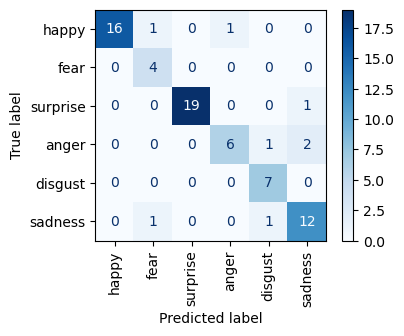

In [16]:
lr = LogisticRegression(random_state=42)
tf = %timeit -o -q -r1 -n1 lr.fit(X_train_scaled, y_train)
findings_raw_coordinates['training_times'][type(lr).__name__] = tf.timings[0]

print_reports(lr, X_train_scaled, y_train, X_test_scaled, y_test, True, findings_raw_coordinates)

**Analysis:**
1. The overall training accuracy is 100% and the testing accuracy is 89%. The difference between the two accuracies indicates a potential overfitting in the model. However, this overfitting is not severe as the difference is not huge. Later, we will check whether tuning the parameters or balancing the dataset may help reduce this overfitting in the logistic regression model.

Regarding the testing results:
1. The precision and recall of the happiness and surprise emotions are pretty high indicating that the model effectively recognizes these emotions.
2. The precision of the fear emotion is the lowest among the emotions (67%) which means that there are a lot of false positives. This could be due to the fact that the dataset is imbalanced and this emotion has a lower number of instances.
3. The recall of the anger emotion very low (67%).  This indicates that the model has a high number of false negatives. Indeed, this is shown in the confusion matrix where the anger emotion is often misclassified as sadness (2 times) or disgust (1 time), which is the highest misclassified class in the whole matrix. This is could be a result of untuned parameters or because this class has the least number of instances so the model cannot predict it well.

We will now tune the hyperparameters of this model and check whether the accuracy will increase.

In [17]:
findings_raw_coordinates_tuned = {
    "training_times": {},
    "prediction_times": {},
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

In [18]:
lr_param_grid = {
    'C': [10, 100],
    'solver': ['newton-cg', 'lbfgs'],
    'penalty': ['l2', None ]
}
lr = LogisticRegression(random_state=42)
best_params = tune_params(lr_param_grid, lr, X_train_scaled, y_train)

C:\Users\HES\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}


In [19]:
lr_tuned_raw = LogisticRegression(random_state=42, **best_params, max_iter=1000)

tf = %timeit -o -q -r1 -n1 lr_tuned_raw.fit(X_train_scaled, y_train)
findings_raw_coordinates_tuned['training_times'][type(lr_tuned_raw).__name__] = tf.timings[0]

print_reports(lr_tuned_raw, X_train_scaled, y_train, X_test_scaled, y_test, False, findings_raw_coordinates_tuned)

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00        54
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        90

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      0.89      0.94        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       0.86      0.67      0.75         9
           5       0.78      1.00      0.88         7
           6       0.80      0.86      0.83        14

    accuracy        

The overall accuracy did not improve with hyperparameter tuning. This could mean that the logistic regression classifier was already performing near its capability given the data. 

The accuracy might improve when handling class imbalance in the second approach. 

#### Stochastic Grdient Descent Classifier:

Training Report:

              precision    recall  f1-score   support

           1       0.99      0.98      0.99       152
           2       0.95      0.97      0.96        98
           3       0.99      1.00      1.00       114
           4       0.96      0.93      0.94        54
           5       0.94      1.00      0.97        62
           6       0.99      0.96      0.97        90

    accuracy                           0.98       570
   macro avg       0.97      0.97      0.97       570
weighted avg       0.98      0.98      0.98       570

Macro F1 Score: 0.971
Testing Report:

              precision    recall  f1-score   support

           1       1.00      0.89      0.94        18
           2       0.36      1.00      0.53         4
           3       1.00      0.90      0.95        20
           4       0.83      0.56      0.67         9
           5       0.78      1.00      0.88         7
           6       0.83      0.71      0.77        14

    accuracy        

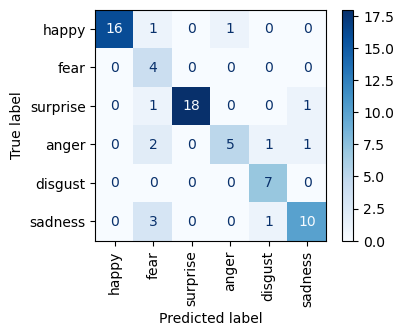

In [20]:
sgd_clf = SGDClassifier(random_state=42)
tf = %timeit -o -q -r1 -n1 sgd_clf.fit(X_train_scaled, y_train)
findings_raw_coordinates['training_times'][type(sgd_clf).__name__] = tf.timings[0]
print_reports(sgd_clf, X_train_scaled, y_train, X_test_scaled, y_test, True, findings_raw_coordinates)

Analysis:
1. The training accuracy is pretty high (98%). This indicates that the model was able to memorize the training data pretty well.
2. The testing accuracy is also fairly high (83%) even with a slight drop in accuracy indicating mild overfitting.
3. Again, the precision and recall of classes 1 and 3 are very high and nearly perfect. This indicates that the model was successful in recognizing these emotions better than the other ones. These 2 emotions have the highest number of instances in the dataset which might explain this observation. 
4. The recall for emotion 4 (anger) is the lowest (0.56). This shows that there are plenty of false negatives as it is also evident in the confusion matrix. According to the confusion matrix, the anger emotion is often misclassified as fear, sadness, or digust.
5. The precission of emotion 2 (fear) is also very low (36%). This indicates that there are plenty of false positives. This is also shown in the confusion matrix where sadness emotion is often misclassified as fear (3 times), anger misclassified as fear (twice) and each of surprise and happiness misclassified as fear once.

Now, we will try to tune the hyperparameters and check for any improvement.

In [21]:
sgd_param_grid = {
    'loss': ['hinge', 'log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [ 0.01],
    'learning_rate': ['optimal', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1]
}

sgd_clf = SGDClassifier(random_state=42)
best_params = tune_params(sgd_param_grid, sgd_clf, X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'penalty': 'l2', 'loss': 'log_loss', 'learning_rate': 'adaptive', 'eta0': 0.01, 'alpha': 0.01}


In [22]:
sgd_clf_tuned_raw = SGDClassifier(**best_params, random_state=42)
tf = %timeit -o -q -r1 -n1 sgd_clf_tuned_raw.fit(X_train_scaled, y_train)
findings_raw_coordinates_tuned['training_times'][type(sgd_clf_tuned_raw).__name__] = tf.timings[0]
print_reports(sgd_clf_tuned_raw, X_train_scaled, y_train, X_test_scaled, y_test, False, findings_raw_coordinates_tuned)

Training Report:

              precision    recall  f1-score   support

           1       0.97      1.00      0.98       152
           2       1.00      0.94      0.97        98
           3       1.00      1.00      1.00       114
           4       0.91      0.80      0.85        54
           5       0.89      1.00      0.94        62
           6       0.96      0.96      0.96        90

    accuracy                           0.96       570
   macro avg       0.95      0.95      0.95       570
weighted avg       0.96      0.96      0.96       570

Macro F1 Score: 0.950
Testing Report:

              precision    recall  f1-score   support

           1       1.00      0.94      0.97        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       0.75      0.67      0.71         9
           5       0.78      1.00      0.88         7
           6       0.77      0.71      0.74        14

    accuracy        

**Analysis:** The testing accuracy of the model increased from 83% before hyperparameter tuning to 88% after tuning the parameters. This indicates that the overall ability of the model to generalize on unseen data has improved.

#### Ridge Classifier:

Training Report:

              precision    recall  f1-score   support

           1       0.96      1.00      0.98       152
           2       0.99      0.93      0.96        98
           3       1.00      1.00      1.00       114
           4       0.98      0.89      0.93        54
           5       0.93      1.00      0.96        62
           6       0.98      0.98      0.98        90

    accuracy                           0.97       570
   macro avg       0.97      0.97      0.97       570
weighted avg       0.97      0.97      0.97       570

Macro F1 Score: 0.968
Testing Report:

              precision    recall  f1-score   support

           1       0.94      0.94      0.94        18
           2       0.50      1.00      0.67         4
           3       1.00      0.95      0.97        20
           4       0.80      0.44      0.57         9
           5       0.88      1.00      0.93         7
           6       0.79      0.79      0.79        14

    accuracy        

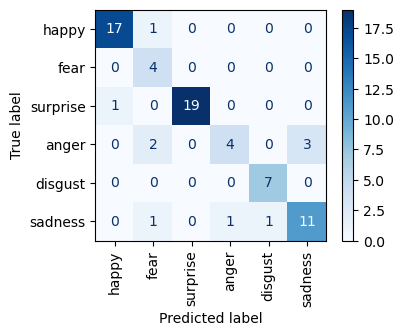

In [23]:
ridge_classifier = RidgeClassifier(random_state=42)
tf = %timeit -o -q -r1 -n1 ridge_classifier.fit(X_train_scaled, y_train)
findings_raw_coordinates['training_times'][type(ridge_classifier).__name__] = tf.timings[0]
print_reports(ridge_classifier, X_train_scaled, y_train, X_test_scaled, y_test, True, findings_raw_coordinates)

Analysis:

1. The training accuracy is pretty high (97%). This indicates that the model was able to predict the training data pretty well.
2. The testing accuracy is also notably high (86%). The small drop in accuracy between the training data and the testing data is perfectly fine and expected, which indicates that is no severe overfitting happening. 
3. The precision and recall of the classes 1 and 3 are very high and nearly perfect. This indicates that the model was successful in recognizing those two emotions better than the other ones. 
4. The recall for emotion 4 is the lowest (0.44). This shows that there are plenty of false negatives as it is also evident in the confusion matrix. According to the confusion matrix, the anger emotion is often misclassified as either sadness or fear.
5. It is noteworthy that classes 1 and 3 with the best precision and recall have the highest number of occurences in the dataset, and class 4 has the lowest number of occurences. Therefore, after balancing the dataset in the next part, an improvement might be shown in the precision and recall of the classes.

In [24]:
ridge_param_grid = {
    'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
}

ridge = RidgeClassifier(random_state=42)
f1_scorer = make_scorer(f1_score, average='micro')
best_params = tune_params(ridge_param_grid, ridge, X_train_scaled, y_train, f1_scorer)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'alpha': 20}


In [25]:
ridge_classifier_tuned_raw = RidgeClassifier(random_state=42, **best_params)
tf = %timeit -o -q -r1 -n1 ridge_classifier_tuned_raw.fit(X_train_scaled, y_train)
findings_raw_coordinates_tuned['training_times'][type(ridge_classifier_tuned_raw).__name__] = tf.timings[0]

print_reports(ridge_classifier_tuned_raw, X_train_scaled, y_train, X_test_scaled, y_test, False, findings_raw_coordinates_tuned)

Training Report:

              precision    recall  f1-score   support

           1       0.92      1.00      0.96       152
           2       0.98      0.88      0.92        98
           3       1.00      0.99      1.00       114
           4       0.98      0.85      0.91        54
           5       0.95      1.00      0.98        62
           6       0.95      0.97      0.96        90

    accuracy                           0.96       570
   macro avg       0.96      0.95      0.95       570
weighted avg       0.96      0.96      0.96       570

Macro F1 Score: 0.954
Testing Report:

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        18
           2       0.50      1.00      0.67         4
           3       1.00      0.95      0.97        20
           4       0.86      0.67      0.75         9
           5       0.88      1.00      0.93         7
           6       0.90      0.64      0.75        14

    accuracy        

**Analysis:**

The testing accuracy of the model increased from 86% before tuning parameters to 88% after tuning them which means that the model's capability of predicting unseen data has improved.

Next, we will we study a more complex model which is the "Random Forest Classifier". We will start by the default parameters and then tune the parameters as before and analyse the results.

#### Random Forest Classifier:

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00        54
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        90

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       0.84      0.89      0.86        18
           2       0.29      0.50      0.36         4
           3       1.00      0.85      0.92        20
           4       0.25      0.11      0.15         9
           5       0.55      0.86      0.67         7
           6       0.71      0.71      0.71        14

    accuracy        

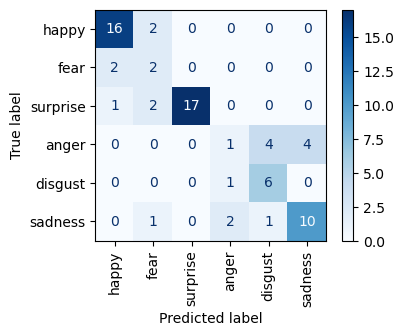

In [26]:
rf = RandomForestClassifier(random_state=42)
tf = %timeit -o -q -r1 -n1 rf.fit(X_train_scaled, y_train)
findings_raw_coordinates['training_times'][type(rf).__name__] = tf.timings[0]
print_reports(rf, X_train_scaled, y_train, X_test_scaled, y_test, True, findings_raw_coordinates)

**Analysis:**

1. The 100% accuracy in training indicates that the model perfectly memorized the training data including noise and outliers and was able to predict it without any errors. This accuracy indicates that overfitting might be taking place.
2. The testing accuracy (72%) is much lower than the training accuracy which means that severe overfitting is taking place.
3. This severe overfitting with such a complex ensemble model as random forest indicates that the decision boundaries for this task are not as complex as Random Forest assumes, leading to poor generalization.

We will now tune the hyperparameters to try to reduce the overfitting:

In [27]:
rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': randint(170, 200),
    'max_depth': [ 5, 10, None],
    'min_samples_split': randint(35, 45),
    'min_samples_leaf': randint(25, 35),
    'max_features': ['sqrt', 'log2']
}

best_params = tune_params(rf_param_grid, rf, X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 26, 'min_samples_split': 39, 'n_estimators': 170}


In [28]:
rf_tuned_raw = RandomForestClassifier(random_state=42, **best_params)
tf = %timeit -o -q -r1 -n1 rf_tuned_raw.fit(X_train_scaled, y_train)
findings_raw_coordinates_tuned['training_times'][type(rf_tuned_raw).__name__] = tf.timings[0]
print_reports(rf_tuned_raw, X_train_scaled, y_train, X_test_scaled, y_test, False, findings_raw_coordinates_tuned)

Training Report:

              precision    recall  f1-score   support

           1       0.79      0.97      0.87       152
           2       0.79      0.49      0.60        98
           3       0.88      0.93      0.90       114
           4       1.00      0.22      0.36        54
           5       0.73      0.84      0.78        62
           6       0.71      0.94      0.81        90

    accuracy                           0.79       570
   macro avg       0.82      0.73      0.72       570
weighted avg       0.81      0.79      0.76       570

Macro F1 Score: 0.722
Testing Report:

              precision    recall  f1-score   support

           1       0.78      1.00      0.88        18
           2       0.25      0.50      0.33         4
           3       1.00      0.70      0.82        20
           4       1.00      0.11      0.20         9
           5       0.56      0.71      0.63         7
           6       0.71      0.86      0.77        14

    accuracy        

**Analysis:**
The training accuracy decreased after hyperparameter tuning. Now, the difference between testing and training accuracy is not as huge as before (only 7%) which is in the acceptable margin. Therefore, there no more severe overfitting in the model. However, the model is still not behaving as good as the previous 3 models indicating that the Random Forest classifier is too complex for our data.

#### Support Vector Machine Classifier:

Next, we will we study the "SVM" model. We will start by the default parameters and then tune the parameters as before and analyse the results.

Training Report:

              precision    recall  f1-score   support

           1       0.96      1.00      0.98       152
           2       0.98      0.94      0.96        98
           3       1.00      1.00      1.00       114
           4       1.00      0.80      0.89        54
           5       0.94      1.00      0.97        62
           6       0.95      1.00      0.97        90

    accuracy                           0.97       570
   macro avg       0.97      0.96      0.96       570
weighted avg       0.97      0.97      0.97       570

Macro F1 Score: 0.961
Testing Report:

              precision    recall  f1-score   support

           1       0.94      0.83      0.88        18
           2       0.40      1.00      0.57         4
           3       0.94      0.85      0.89        20
           4       0.20      0.11      0.14         9
           5       0.57      0.57      0.57         7
           6       0.62      0.71      0.67        14

    accuracy        

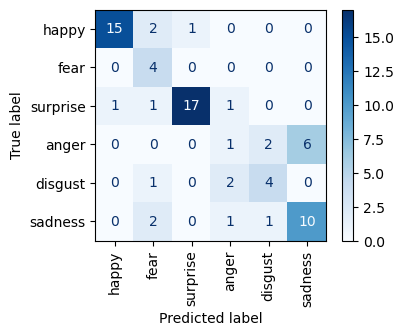

In [29]:
svm = SVC(random_state=42)
tf = %timeit -o -q -r1 -n1 svm.fit(X_train_scaled, y_train)
findings_raw_coordinates['training_times'][type(svm).__name__] = tf.timings[0]
print_reports(svm, X_train_scaled, y_train, X_test_scaled, y_test, True, findings_raw_coordinates)

**Analysis:**

1. Similar to the random forest classifier, the SVM classifer is exibiting severe overfitting with training accuracy equal to 97% and a testing accuracy equal to 71%.

We will now tune the hyperparameters of the SVM model and notice whether any improvement will take place.

In [30]:
svc_param_grid = {
    'C': np.logspace(-3, 2, 6),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-4, 1, 6)
}
svc = SVC(random_state=42)
best_params = tune_params(svc_param_grid, svc, X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}


In [31]:
svm_tuned_raw = SVC(random_state=42, **best_params)
tf = %timeit -o -q -r1 -n1 svm_tuned_raw.fit(X_train_scaled, y_train)
findings_raw_coordinates_tuned['training_times'][type(svm_tuned_raw).__name__] = tf.timings[0]
print_reports(svm_tuned_raw, X_train_scaled, y_train, X_test_scaled, y_test, False, findings_raw_coordinates_tuned)

Training Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       152
           2       1.00      0.99      0.99        98
           3       1.00      1.00      1.00       114
           4       0.96      0.93      0.94        54
           5       0.94      1.00      0.97        62
           6       1.00      0.98      0.99        90

    accuracy                           0.99       570
   macro avg       0.98      0.98      0.98       570
weighted avg       0.99      0.99      0.99       570

Macro F1 Score: 0.982
Testing Report:

              precision    recall  f1-score   support

           1       1.00      0.89      0.94        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       0.88      0.78      0.82         9
           5       0.88      1.00      0.93         7
           6       0.80      0.86      0.83        14

    accuracy        

**Analysis:**
1. Tuning the hyperparameters yielded impressive results as the testing accuracy increased from 71% to 90%.
2. The precision and recall for all classes improved which indicates that the model is more balanced now and can generalize better for unseen data.
3. From the preceding results, we can conclude that the overall performance of the model increased which means that the model is generalizing better on unseen data after performing hyperparameter tuning.
4. Since after tuning the hyperparameters the new kernel value became "linear", this indicates that indeed the relationships between the feautures of the data is linear to some extent since the "linear" kernel performed much better than the default one.

#### MLP Classifier:

Next, we will we study the "MLP" model. We will start by the default parameters and then tune the parameters as before and analyse the results.

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00        54
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        90

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       0.89      0.94      0.92        18
           2       1.00      1.00      1.00         4
           3       1.00      0.90      0.95        20
           4       0.60      0.67      0.63         9
           5       0.75      0.86      0.80         7
           6       0.77      0.71      0.74        14

    accuracy        

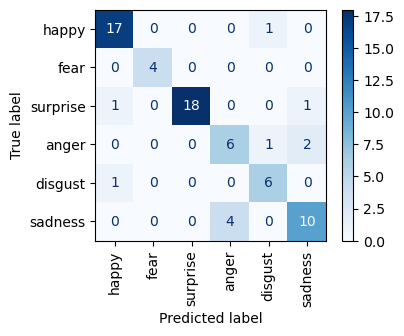

In [32]:
mlp = MLPClassifier(random_state = 42, max_iter=1000)
tf = %timeit -o -q -r1 -n1 mlp.fit(X_train_scaled, y_train)
findings_raw_coordinates['training_times'][type(mlp).__name__] = tf.timings[0]
print_reports(mlp, X_train_scaled, y_train, X_test_scaled, y_test, True, findings_raw_coordinates)

Analysis:

1. Again, and as the previous model, this classifier has mild overfitting with a training accuracy equal to 100% and a testing accuracy equal to 85%.
2. Also, once again, this model is performing much better on classes 1 and 3 than the other classes. Class 4 also once again has the lowest recall and precision. This might be because of the unbalanced dataset or untuned parameters.

We will perform hyperparamter tuning on this model next.

In [33]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50)],
    'activation': ['tanh', 'relu'], 
    'solver': ['sgd', 'adam'],
    'alpha':[1, 10, 50, 100],
    'learning_rate': ['constant', 'adaptive'],
}
mlp = MLPClassifier(random_state = 42)
best_params = tune_params(mlp_param_grid, mlp, X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 1, 'activation': 'tanh'}


C:\Users\HES\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
mlp_tuned_raw = MLPClassifier(random_state = 42, **best_params, max_iter=1000)
tf = %timeit -o -q -r1 -n1 mlp_tuned_raw.fit(X_train_scaled, y_train)
findings_raw_coordinates_tuned['training_times'][type(mlp_tuned_raw).__name__] = tf.timings[0]
print_reports(mlp_tuned_raw, X_train_scaled, y_train, X_test_scaled, y_test, False, findings_raw_coordinates_tuned)

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00        54
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        90

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00         4
           3       1.00      0.95      0.97        20
           4       0.86      0.67      0.75         9
           5       0.88      1.00      0.93         7
           6       0.81      0.93      0.87        14

    accuracy        

Analysis: 

After tuning the hyperparameters, the testing accuracy increased from 85% to 93%. There no evident overfitting taking place and the model performs extremely well on unseen data making it the best model we tried so far.

The following table shows the testing accuracies of the different models that we worked on:
<table style="border: 1px solid black; border-collapse: collapse;">
    <tr style="border: 1px solid black;">
        <th style="border: 1px solid black; padding:5px;">Logistic Regression </th>
        <th style="border: 1px solid black; padding:5px;">Stochastic Gradient Descent</th>
        <th style="border: 1px solid black; padding:5px;">Rigde</th>
        <th style="border: 1px solid black; padding:5px;">Random Forest</th>
        <th style="border: 1px solid black; padding:5px;">Support Vector Machines</th>
        <th style="border: 1px solid black; padding:5px;">MLP</th>
    </tr>
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black; padding:5px;">89%</td>
        <td style="border: 1px solid black; padding:5px;">88%</td>
        <td style="border: 1px solid black; padding:5px;">88%</td>
        <td style="border: 1px solid black; padding:5px;">72%</td>
        <td style="border: 1px solid black; padding:5px;">90%</td>
        <td style="border: 1px solid black; padding:5px; background-color: yellow;">93%</td>
    </tr>
</table>

The best accuracy that we were able to achieve is 93% with the MLP classifier which is considered an excellent accuracy indicating that this model was able to generalize very well on unseen data.

Next, we will plot the barcharts of the accuracies and the macro-f1 scores before and after parameter tuning to visualize their improvement.

In [35]:
labels = ['Logistic Reg.', 'SGD', 'Ridge', 'Random Forest', 'SVC', 'MLP']
def plot_comparison(before_tuning, after_tuning, metric_name, change_name):
    before_values = list(before_tuning.values())
    after_values = list(after_tuning.values())

    x = np.arange(len(labels))

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - 0.225, before_values, 0.45, label='Before '+change_name)
    bars2 = ax.bar(x + 0.225, after_values, 0.45, label='After '+change_name)

    ax.set_ylabel(metric_name)
    ax.set_title(metric_name+' by Model and '+change_name +' Status')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    autolabel(bars1)
    autolabel(bars2)
    plt.tight_layout()
    plt.show()

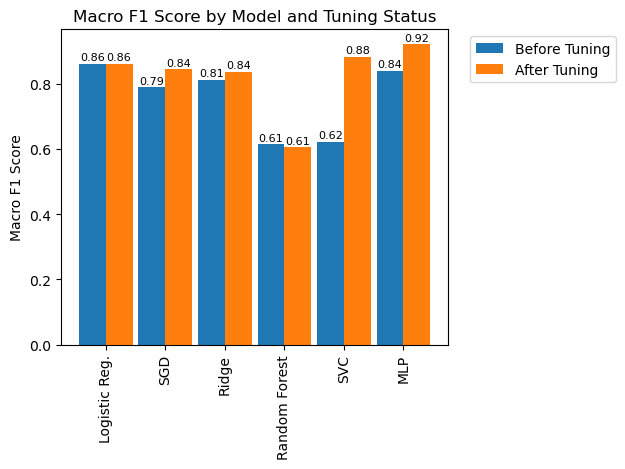

In [36]:
plot_comparison(findings_raw_coordinates["macro_f1_scores"], findings_raw_coordinates_tuned["macro_f1_scores"], "Macro F1 Score", "Tuning")

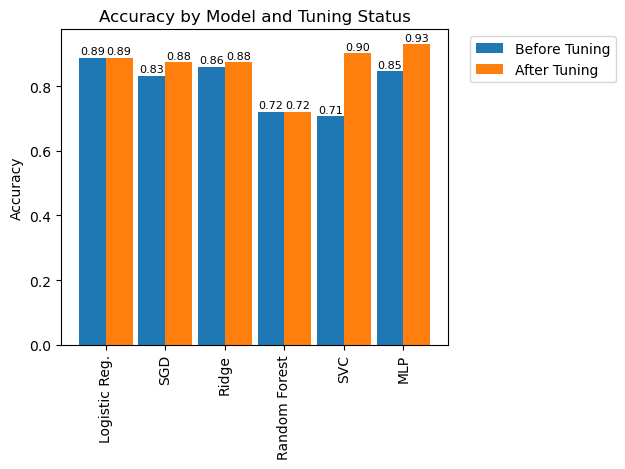

In [37]:
plot_comparison(findings_raw_coordinates["overall_accuracies"], findings_raw_coordinates_tuned["overall_accuracies"], "Accuracy", "Tuning")

The previous 2 figures summarize the accuracy and f1 scores before and after parameter tuning. As explained before in details, parameter tuning improved the models' capabilities to generalize on unseen data resulting in better accuracy and f1 score values.

Next we will take a look at the training and prediction times of the different models.

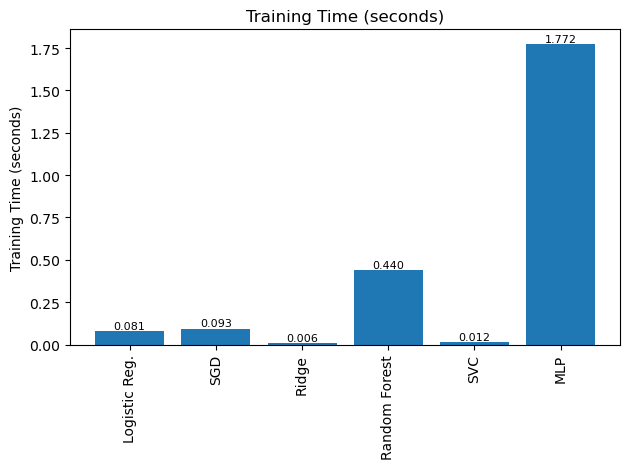

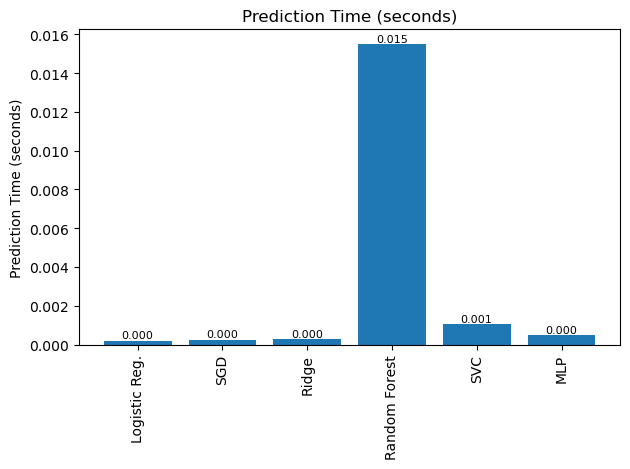

In [38]:
def plot_metric(metric_name, metric_values):
    names = ['Logistic Reg.', 'SGD', 'Ridge', 'Random Forest', 'SVC', 'MLP']
    values = list(metric_values.values())

    plt.bar(names, values)
    plt.title(metric_name)
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)
    for i, v in enumerate(values):
        plt.text(i, v + max(values) * 0.001, f"{v:.3f}", ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

plot_metric("Training Time (seconds)", findings_raw_coordinates_tuned["training_times"])
plot_metric("Prediction Time (seconds)", findings_raw_coordinates_tuned["prediction_times"])

**Analysis**:

1. The first graph shows the training time in seconds of the different models trained above. The ridge classifier was the fastest to train indicating that it is computationally the least intensive among the models chosen.
2. Random forest and MLP were the slowest to train. This is expected due to their complex nature. For exmaple, random forest needs to train several decision trees which takes time. The MLP classifier as well, being a neural network model, is more complex and requires more computational resources and time to train.
3. We can see that as the complexity of the model increases, its training time increases. 
4. The second graph shows the prediction time in seconds for the different models. As expected for linear models such as ridge classifier, logistic regression, and SGD, these models are extremely fast in making predictions (1 millisecond or less according to the figure).
5. The random forest classifier was the slowest in making predictions (32 milliseconds). This is also expected as this model needs to aggregate predictions from several decision trees which takes time.

Next, we will check whether training the models on a smaller set would have resulted in similar accuracies. As it is known, training on smaller sets is more efficient but it is not guaranteed to produce accurate results. If we could achieve the same results as above with a smaller set, it means that we can decrease the size of our training set to make learning faster.

In [39]:
def plot_accuracy_per_size(models, X_train, y_train, X_test, y_test, data_portions):
    accuracies = {label: [] for label in labels}

    size_of_data = []
    for size in data_portions:
        end_index = int(size * len(X_train))
        size_of_data.append(end_index)
        X_train_subset = X_train[:end_index]
        y_train_subset = y_train[:end_index]

        for model, acc in zip(models, list(accuracies.keys())):
            model.fit(X_train_subset, y_train_subset)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            accuracies[acc].append(accuracy)

    for model_name, acc in accuracies.items():
        plt.plot(size_of_data, acc, label=model_name)

    plt.xlabel('Data Size')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy as a Function of Training Data Size')
    plt.legend()
    plt.show()

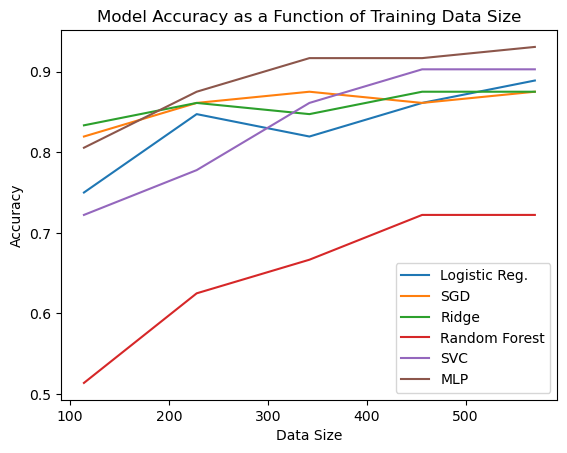

In [40]:
data_portions = [0.2, 0.4, 0.6, 0.8, 1.0]
models_tuned_raw = [lr_tuned_raw, sgd_clf_tuned_raw, ridge_classifier_tuned_raw, rf_tuned_raw, svm_tuned_raw, mlp_tuned_raw]
plot_accuracy_per_size(models_tuned_raw, X_train_scaled, y_train, X_test_scaled, y_test, data_portions)

**Analysis**: As it can be seen from the figure, as the training set size increases, the accuracy of the model increases. Therefore, it is not advisable in our case to reduce the size of the training set.

### II. Predict emotions using points' displacement between the neutral and apex images

The following method calculates the displacements between the apex and the neutral image in a dataframe.

In [41]:
def calculate_displacements(df):
    displacement_array = []
    for (_, __), group in df.groupby(['subject', 'file']):
        neutral_image, apex_image = group.iloc[0], group.iloc[-1]
        displacement = apex_image[[i for i in range(1, 137)]] - neutral_image[[i for i in range(1, 137)]]
        displacement_array.append(displacement.tolist() + [apex_image['emotion']])
    return pd.DataFrame(displacement_array, columns=[i for i in range(1, 137)] + ['emotion'])

We created a new dataframe that contains the displacement of each image along with the emotion, then we scaled the data with standard scaler.

In [42]:
displacement_df = calculate_displacements(combined_df_aligned)

X = displacement_df.drop('emotion', axis=1)
y = displacement_df['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled_disp, X_test_scaled_disp, y_train_disp, y_test_disp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [43]:
findings_displacement = {
    "training_times": {},
    "prediction_times": {},
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

Now, we will train the previous models again and check if their performance is better than the first approach.

#### Logistic Regression:

C:\Users\HES\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        45

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       1.00      0.67      0.80         9
           5       0.88      1.00      0.93         7
           6       0.80      0.86      0.83        14

    accuracy        

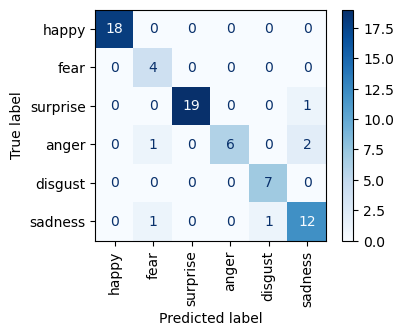

In [44]:
lr = LogisticRegression(random_state=42)
tf = %timeit -o -q -r1 -n1 lr.fit(X_train_scaled_disp, y_train_disp)
findings_displacement['training_times'][type(lr).__name__] = tf.timings[0]

print_reports(lr, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, True, findings_displacement)

**Analysis**: Indeed, and as it is obvious, the logistic regression model's testing accuracy is now 92% which is a very high accuracy. Furthermore, the overall precision, recall, and f1 score of the different classes increased meaning that the model is now more successful in prediction. For example, the precision of class 4 increased from 0.86 to 1, and the recall of class 1 increased from 0.89 to 1 as well to mention a few.

Next, we will try to tune the parameters and check whether any further improvement could be achieved.

In [45]:
findings_displacement_tuned = {
    "training_times": {},
    "prediction_times": {},
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

In [46]:
lr = LogisticRegression(random_state=42)
best_params = tune_params(lr_param_grid, lr, X_train_scaled_disp, y_train_disp)

C:\Users\HES\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}


In [47]:
lr_tuned_disp = LogisticRegression(random_state=42, **best_params, max_iter=1000)
tf = %timeit -o -q -r1 -n1 lr_tuned_disp.fit(X_train_scaled_disp, y_train_disp)
findings_displacement_tuned['training_times'][type(lr_tuned_disp).__name__] = tf.timings[0]

print_reports(lr_tuned_disp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, False, findings_displacement_tuned)

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        45

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       1.00      0.67      0.80         9
           5       0.88      1.00      0.93         7
           6       0.80      0.86      0.83        14

    accuracy        

**Analysis**: The overall testing accuracy and macro f1 score did not increase. It might be because the model was already performing at its best before parameter tuning.

#### Stochastic Gradient Descent:

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       0.98      1.00      0.99        57
           4       1.00      0.96      0.98        27
           5       1.00      1.00      1.00        31
           6       0.98      0.98      0.98        45

    accuracy                           0.99       285
   macro avg       0.99      0.99      0.99       285
weighted avg       0.99      0.99      0.99       285

Macro F1 Score: 0.992
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.80      1.00      0.89         4
           3       0.95      0.95      0.95        20
           4       1.00      0.67      0.80         9
           5       0.88      1.00      0.93         7
           6       0.80      0.86      0.83        14

    accuracy        

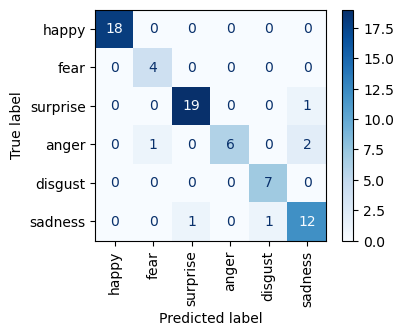

In [48]:
sgd_clf = SGDClassifier(random_state=42)
tf = %timeit -o -q -r1 -n1 sgd_clf.fit(X_train_scaled_disp, y_train_disp)
findings_displacement['training_times'][type(sgd_clf).__name__] = tf.timings[0]

print_reports(sgd_clf, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, True, findings_displacement)

**Analysis**: Again, with this new approach, the accuracy of the SGD model improved to reach 92% (before tuning). The model performs very well as the precision of all classes is above 80% with some classes having a precision of 100% as well meaning that the number of false positives is minimal. 

We will now tune the parameters and check if any improvement could be achieved.

In [49]:
sgd = SGDClassifier(random_state=42)

best_params = tune_params(sgd_param_grid, sgd, X_train_scaled_disp, y_train_disp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'penalty': 'elasticnet', 'loss': 'log_loss', 'learning_rate': 'adaptive', 'eta0': 0.1, 'alpha': 0.01}


In [50]:
sgd_tuned_disp = SGDClassifier(random_state=42, **best_params)
tf = %timeit -o -q -r1 -n1 sgd_tuned_disp.fit(X_train_scaled_disp, y_train_disp)
findings_displacement_tuned['training_times'][type(sgd_tuned_disp).__name__] = tf.timings[0]

print_reports(sgd_tuned_disp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, False, findings_displacement_tuned)

Training Report:

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        76
           2       1.00      0.90      0.95        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       0.98      1.00      0.99        45

    accuracy                           0.98       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.98      0.98      0.98       285

Macro F1 Score: 0.985
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00         4
           3       0.95      0.95      0.95        20
           4       1.00      0.78      0.88         9
           5       0.88      1.00      0.93         7
           6       0.80      0.86      0.83        14

    accuracy        

**Analysis**: Indeed, there is a slight increase in the overall accuracy of the model (93%), and the macro f1 score also increased from 0.9 to 0.93 after tuning. Furthermore, the recall of class 4 increased from 0.67 before tuning to 0.78 after tuning which means that the number of instances of class 4 which are misclassified as other classes dropped which is a very good sign.

#### Ridge Classifier:

Training Report:

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        76
           2       1.00      0.92      0.96        49
           3       1.00      1.00      1.00        57
           4       1.00      0.96      0.98        27
           5       1.00      1.00      1.00        31
           6       0.98      1.00      0.99        45

    accuracy                           0.98       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.98      0.98      0.98       285

Macro F1 Score: 0.984
Testing Report:

              precision    recall  f1-score   support

           1       1.00      0.94      0.97        18
           2       0.57      1.00      0.73         4
           3       1.00      0.95      0.97        20
           4       1.00      0.33      0.50         9
           5       0.78      1.00      0.88         7
           6       0.71      0.86      0.77        14

    accuracy        

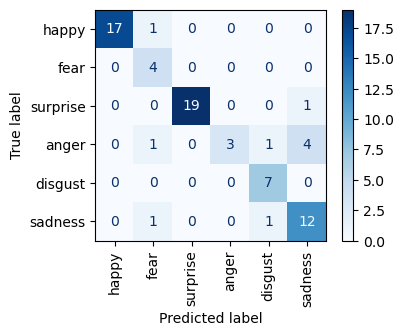

In [51]:
ridge_classifier = RidgeClassifier(random_state=42)

tf = %timeit -o -q -r1 -n1 ridge_classifier.fit(X_train_scaled_disp, y_train_disp)
findings_displacement['training_times'][type(ridge_classifier).__name__] = tf.timings[0]

print_reports(ridge_classifier, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, True, findings_displacement)

**Analysis**: The overall performance of the ridge classifier before parameter tuning in this approach is similar to that in the previous approach. Therefore, cosidering the displacement of points instead of raw coordinates did not improve the Ridge classifier. Furthermore, this model seems to struggle greatly with class number 4 (anger) which has a very low recall of 0.33 indicating a high number of false negatives and class 2 (fear) which has a very low precision of 0.57 indicating a high number of false positives. This observation is asserted by the confusion matrix which shows that anger is often misclassified as either sadness, disgust, or fear, and that classes such as happiness, anger, and sadness are sometimes misclassied as fear.

We will now tune the parameters and check whether this time the Ridge classifier will perform better than in the "raw coordinates approach".

In [52]:
ridge_classifier = RidgeClassifier(random_state=42)
best_params = tune_params(ridge_param_grid, ridge_classifier, X_train_scaled_disp, y_train_disp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'alpha': 55}


In [53]:
ridge_classifier_tuned_disp = RidgeClassifier(random_state=42, **best_params)

tf = %timeit -o -q -r1 -n1 ridge_classifier_tuned_disp.fit(X_train_scaled_disp, y_train_disp)
findings_displacement_tuned['training_times'][type(ridge_classifier_tuned_disp).__name__] = tf.timings[0]

print_reports(ridge_classifier_tuned_disp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, False, findings_displacement_tuned)

Training Report:

              precision    recall  f1-score   support

           1       0.89      1.00      0.94        76
           2       1.00      0.76      0.86        49
           3       0.97      1.00      0.98        57
           4       1.00      0.74      0.85        27
           5       0.94      1.00      0.97        31
           6       0.88      1.00      0.94        45

    accuracy                           0.93       285
   macro avg       0.95      0.92      0.92       285
weighted avg       0.94      0.93      0.93       285

Macro F1 Score: 0.924
Testing Report:

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       0.80      1.00      0.89         4
           3       1.00      0.95      0.97        20
           4       1.00      0.44      0.62         9
           5       0.88      1.00      0.93         7
           6       0.76      0.93      0.84        14

    accuracy        

**Analysis**: After tuning the parameters, the overall accuracy of the model inreased from 86% to 90%, and the macro f1 score increased from 0.8 to 0.87. This is a pretty high accuracy and f1 score which indicates that the Ridge classifier was able to predict accurately unseen data. Moreover, this accuracy is higher than the accuracy that the same model had in "raw coordinates" approach. Therefore, considering the displacement of coordinates between the neutral and apex image made the model more accurate than before.

#### Random Forest Classifier:

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        45

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.57      1.00      0.73         4
           3       1.00      0.90      0.95        20
           4       1.00      0.78      0.88         9
           5       0.88      1.00      0.93         7
           6       0.86      0.86      0.86        14

    accuracy        

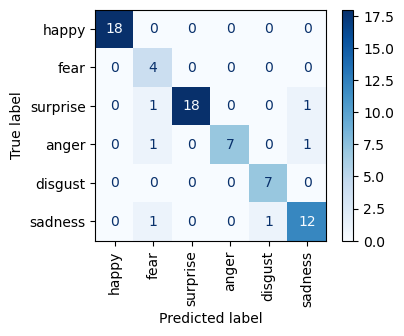

In [54]:
rf = RandomForestClassifier(random_state=42)
tf = %timeit -o -q -r1 -n1 rf.fit(X_train_scaled_disp, y_train_disp)
findings_displacement['training_times'][type(rf).__name__] = tf.timings[0]

print_reports(rf, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, True, findings_displacement)

**Analysis**: The testing accuracy of the Random Forest Classifier is very impressive (92%). This is much more higher than the accuracy in the previous approach which was only 72%. Furthermore, there no longer a severe overfitting in the model as before. Obviously, the Random Forest Classifier is performing much better in the new dataset with displacements that it did with raw coordinates. 

We will now tune the parameters in hope for yielding even better results by this model.

In [55]:
rf = RandomForestClassifier(random_state=42)

new_rf_param_grid = {
    "max_depth": [30, 50, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf":[1, 3, 5],
    "max_features":  ['sqrt', 'log2']
}

best_params = tune_params(new_rf_param_grid, rf, X_train_scaled_disp, y_train_disp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}


In [56]:
rf_tuned_disp = RandomForestClassifier(random_state=42, **best_params)
tf = %timeit -o -q -r1 -n1 rf_tuned_disp.fit(X_train_scaled_disp, y_train_disp)
findings_displacement_tuned['training_times'][type(rf_tuned_disp).__name__] = tf.timings[0]

print_reports(rf_tuned_disp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, False, findings_displacement_tuned)

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        45

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.57      1.00      0.73         4
           3       1.00      0.90      0.95        20
           4       1.00      0.78      0.88         9
           5       0.88      1.00      0.93         7
           6       0.86      0.86      0.86        14

    accuracy        

**Analysis**: Tuning the parameters did not increase the accuracy in this model. The reason behind this could be that either the model was already performing its best given this dataset, or the random search did not capture the optimal combination of parameters as it does not perform a thorough search as the Grid Search does. Anyways, the accuracy is already high (92%) indicating that the model generalizes very well on unseen data.

#### SVM Classifier:

Training Report:

              precision    recall  f1-score   support

           1       0.93      1.00      0.96        76
           2       1.00      0.86      0.92        49
           3       1.00      1.00      1.00        57
           4       1.00      0.85      0.92        27
           5       1.00      1.00      1.00        31
           6       0.90      1.00      0.95        45

    accuracy                           0.96       285
   macro avg       0.97      0.95      0.96       285
weighted avg       0.96      0.96      0.96       285

Macro F1 Score: 0.959
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.80      1.00      0.89         4
           3       0.95      0.95      0.95        20
           4       1.00      0.56      0.71         9
           5       0.78      1.00      0.88         7
           6       0.80      0.86      0.83        14

    accuracy        

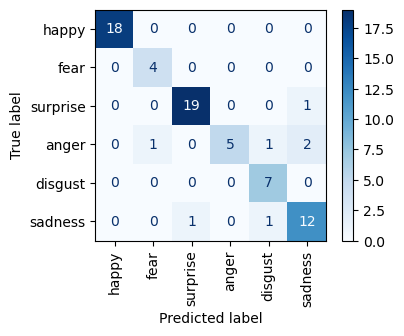

In [57]:
svm = SVC(random_state=42)
tf = %timeit -o -q -r1 -n1 svm.fit(X_train_scaled_disp, y_train_disp)
findings_displacement['training_times'][type(svm).__name__] = tf.timings[0]

print_reports(svm, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, True, findings_displacement)

**Analysis**: After using the displacement of points instead of raw coordinates, the accuracy of the model before tuning increased from 71% to 90%. This is a very impressive accuracy which shows the model's ability to generalize well to unseen data. However, the model is still struggling with certain classes such as class 4 which has an extremely low recall of 0.56. This low recall signals that there are a lot of false negatives. This is also obvious in the confusion matrix as the anger emotion is often misclassified as sadness, disgust, or fear. This might be because this class is underrepresented in the training set (has the lowest support), so the model was not successful in detecting it accurately. This behaviour might change when we balance class representations in the next part of the project.

Next, we will tune the parameters to check whether we can achieve an accuracy higher than 90% with the SVM classifier.

In [58]:
svc = SVC(random_state=42)
svc_new_param_grid = {
    'C': [0.001, 0.01, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-4, 1, 6)
}
best_params = tune_params(svc_new_param_grid, svc, X_train_scaled_disp, y_train_disp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 1}


In [59]:
svm_tuned_disp = SVC(random_state=42, **best_params)
tf = %timeit -o -q -r1 -n1 svm_tuned_disp.fit(X_train_scaled_disp, y_train_disp)
findings_displacement_tuned['training_times'][type(svm_tuned_disp).__name__] = tf.timings[0]
print_reports(svm_tuned_disp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, False, findings_displacement_tuned)

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        45

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       1.00      0.67      0.80         9
           5       0.88      1.00      0.93         7
           6       0.80      0.86      0.83        14

    accuracy        

**Analysis:** Tuning the parameters resulted in a small increase in the overall accuracy of the model from 90% to 92%. Furthermore, the recall of class 4 which was 0.56 before increased to 0.67 now which might not be a major increase, but still is better than before.

#### MLP Classifier:

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        45

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       0.67      1.00      0.80         4
           3       1.00      0.95      0.97        20
           4       0.86      0.67      0.75         9
           5       0.88      1.00      0.93         7
           6       0.85      0.79      0.81        14

    accuracy        

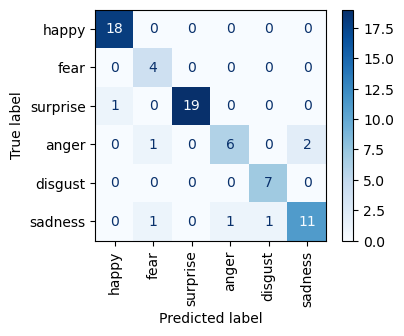

In [60]:
mlp = MLPClassifier(random_state = 42, max_iter=1000)
tf = %timeit -o -q -r1 -n1 mlp.fit(X_train_scaled_disp, y_train_disp)
findings_displacement['training_times'][type(mlp).__name__] = tf.timings[0]

print_reports(mlp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, True, findings_displacement)

**Analysis**: The accuracy of the MLP classifier increased from 85% in raw coordinates approach before tuning to 90% in the displacement approach. This is a major increase which shows how the new approach made the model more able to generalize to unseen data. 

We willl tune its parameters next in hopes of getting even a higher accuracy.

In [61]:
mlp = MLPClassifier(random_state = 42)

best_params = tune_params(mlp_param_grid, mlp, X_train_scaled_disp, y_train_disp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 1, 'activation': 'tanh'}


C:\Users\HES\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [62]:
mlp_tuned_disp = MLPClassifier(random_state = 42, max_iter=5000, **best_params)
tf = %timeit -o -q -r1 -n1 mlp_tuned_disp.fit(X_train_scaled_disp, y_train_disp)
findings_displacement_tuned['training_times'][type(mlp_tuned_disp).__name__] = tf.timings[0]

print_reports(mlp_tuned_disp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, False, findings_displacement_tuned)

Training Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        45

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Macro F1 Score: 1.000
Testing Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.80      1.00      0.89         4
           3       1.00      0.95      0.97        20
           4       0.88      0.78      0.82         9
           5       1.00      1.00      1.00         7
           6       0.87      0.93      0.90        14

    accuracy        

**Analysis**: Indeed, tuning the parameters resulted in an increase in the overall accuracy from 90% to 94% which is a very impressive accuracy and is higher than all the accuracies that we achieved thus far by any model. Furthermore, the presicion and recall of all classes are high showing how successful the model is in detecting them correctly.

The following table shows the testing accuracies of the different models that we worked on in this approach:
<table style="border: 1px solid black; border-collapse: collapse;">
    <tr style="border: 1px solid black;">
        <th style="border: 1px solid black; padding:5px;">Logistic Regression </th>
        <th style="border: 1px solid black; padding:5px;">Stochastic Gradient Descent</th>
        <th style="border: 1px solid black; padding:5px;">Rigde</th>
        <th style="border: 1px solid black; padding:5px;">Random Forest</th>
        <th style="border: 1px solid black; padding:5px;">Support Vector Machines</th>
        <th style="border: 1px solid black; padding:5px;">MLP</th>
    </tr>
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black; padding:5px;">92%</td>
        <td style="border: 1px solid black; padding:5px;">93%</td>
        <td style="border: 1px solid black; padding:5px;">90%</td>
        <td style="border: 1px solid black; padding:5px;">92%</td>
        <td style="border: 1px solid black; padding:5px;">92%</td>
        <td style="border: 1px solid black; padding:5px; background-color: yellow;">94%</td>
    </tr>
</table>

All the accuracies are pretty high and above 90%. This approach clearly represents data in a better way than the previous one allowing the models to learn it better and make more informed and accurate predictions on unseen data.
The best accuracy that we were able to achieve is 94% with the MLP classifier which is considered an excellent accuracy indicating that this model was able to generalize very well on unseen data.

Next, we will plot the barcharts of the accuracies and the macro-f1 scores before and after parameter tuning to visualize their improvement.

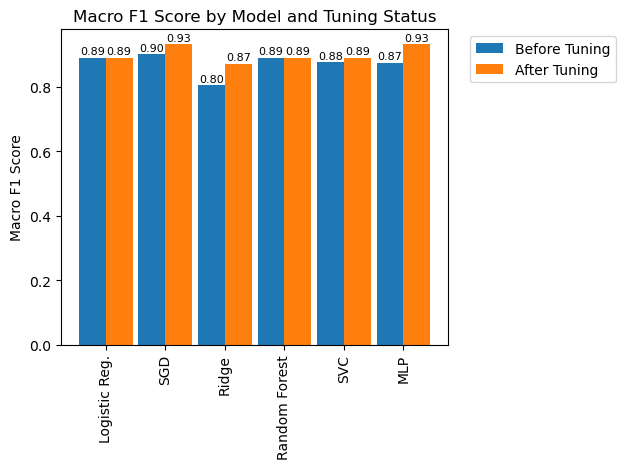

In [63]:
plot_comparison(findings_displacement["macro_f1_scores"], findings_displacement_tuned["macro_f1_scores"], "Macro F1 Score", "Tuning")

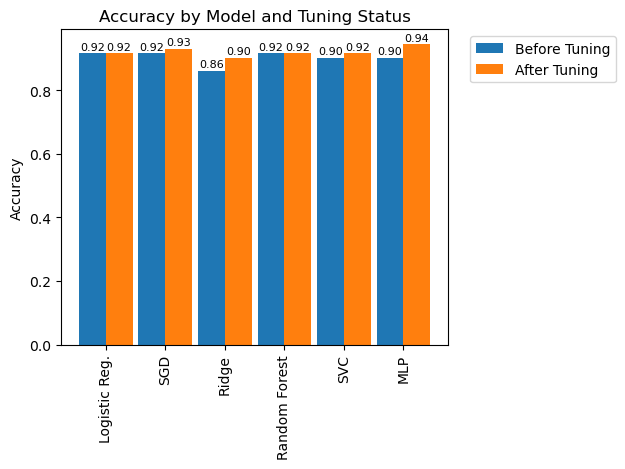

In [64]:
plot_comparison(findings_displacement["overall_accuracies"], findings_displacement_tuned["overall_accuracies"], "Accuracy", "Tuning")

The previous 2 figures summarize the accuracy and f1 scores before and after parameter tuning. As explained before in details, parameter tuning improved the models' capabilities to generalize on unseen data resulting in better accuracy and f1 score values.

Next, we will take a look at the training and prediction times for those models.

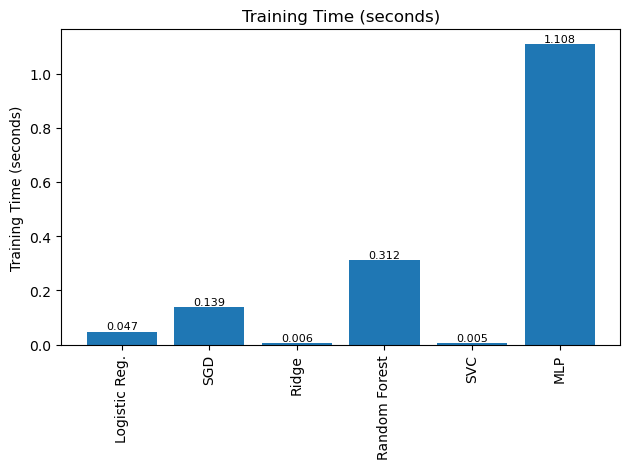

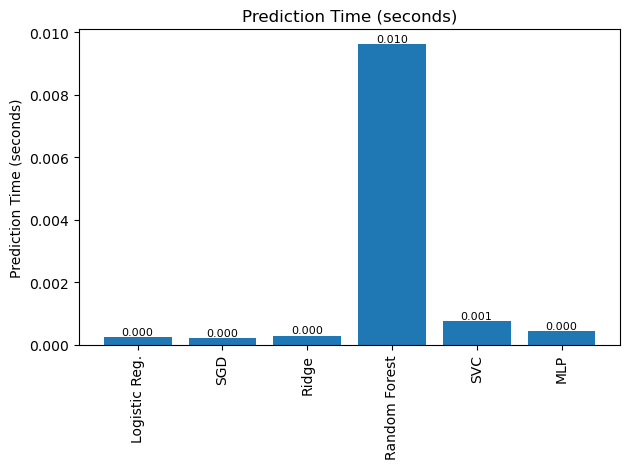

In [65]:
plot_metric("Training Time (seconds)", findings_displacement_tuned["training_times"])
plot_metric("Prediction Time (seconds)", findings_displacement_tuned["prediction_times"])

**Analysis**:
1. Again, the ridge classifier had the quickest training time, suggesting it's the least computationally demanding of the selected models.
2. Also, the training time for random forest and MLP classifiers was notably longer. This aligns with their inherent complexity. For instance, the random forest requires the construction of multiple decision trees which is a time-consuming process. Similarly, the MLP classifier, as a neural network, demands greater computational power and more time for training.
3. It is evident that an increase in model complexity correlates with longer training times.
4. The second chart illustrates the time taken for predictions by different models. Linear models like the ridge classifier, logistic regression, and SGD are remarkably quick in making predictions, typically less than 1 millisecond as the data indicates.
5. The random forest classifier took the longest for predictions (14 milliseconds). This is anticipated, since it aggregates predictions from numerous decision trees, which is a time-intensive process.

Next, we'll verify wether training the models with a smaller dataset could produce the same accuracies. It's known that training with smaller datasets is typically more efficient. However, one cannot be assured in that case of getting a high accuracy. If we manage to get similar outcomes as before with a smaller set, it indicates the possibility of reducing our training dataset to make the learning process faster.

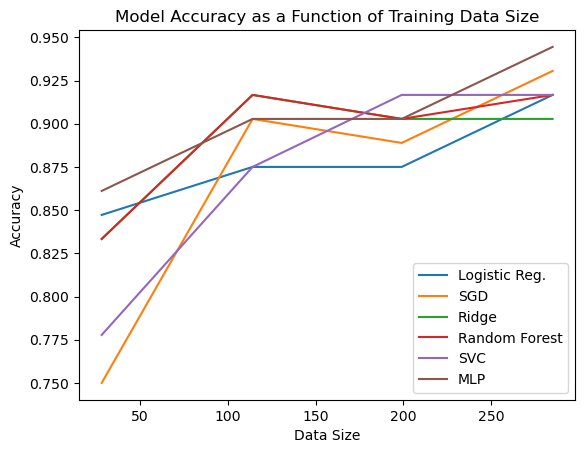

In [66]:
data_portions = [0.1, 0.4, 0.7, 1]
models_tuned_disp = [lr_tuned_disp, sgd_tuned_disp, ridge_classifier_tuned_disp, rf_tuned_disp, svm_tuned_disp, mlp_tuned_disp]
plot_accuracy_per_size(models_tuned_disp, X_train_scaled_disp, y_train_disp, X_test_scaled_disp, y_test_disp, data_portions)

Again, the results show that as the data size increases, the model's accuracy increases. Therefore, using the whole dataset provided without reducing it was a wise choise.

# Second Approach: Handling Imbalance

Since the dataset is heavily unbalanced, we will use SMOTE to do oversampling.

**We will compare the *macro F1 score* of the models before and after oversampling. The reason behind choosing the macro f1 score as a performance metric is because it is more informative than accuracy in cases of unbalanced datasets. In such cases, the model could always predict the overrepresented class and still achieve a high accuracy. However, macro f1 score gives an equal weight to all classes making them all equally important regardless of their number of instances. Therefore, choosing macro f1 score is a better choice in our case.**

In [67]:
smote = SMOTE(random_state=42)

We will split the dataset first, then apply SMOTE on training data only to avoid testing the synthetic samples or any data leakages.

In [68]:
displacement_df = calculate_displacements(combined_df)
X = displacement_df[[i for i in range(1, 137)]]
y = displacement_df['emotion']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [69]:
X_train_smote, y_train_smote = smote.fit_resample(X_train_disp, y_train_disp)

We will create the following 2 dictionaries to save important data for figures later on.

In [70]:
findings_balanced = {
    "training_times": {},
    "prediction_times": {},
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

In [71]:
findings_balanced_tuned = {
    "training_times": {},
    "prediction_times": {},
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

We will define all functions beforehand and prepare them. The analysis of the results will be made in the end of this section.

The following function will be used to train a model, create predictions, and populate the corresponding dictionary:

In [72]:
def train_predict(model, train_X, train_y, test_X, test_y, dictionary):
    tf = %timeit -o -q -r1 -n1 model.fit(train_X, train_y)
    dictionary['training_times'][type(model).__name__] = tf.timings[0]

    sessions_predictions = []
    def get_pred():
        nonlocal sessions_predictions
        sessions_predictions = model.predict(test_X)
        
    tp = %timeit -o -q -r1 -n1 get_pred()
    macro_f1_score = f1_score(test_y, sessions_predictions, average='macro')
    model_name = type(model).__name__
    dictionary['overall_accuracies'][model_name] = accuracy_score(test_y, sessions_predictions)
    dictionary['prediction_times'][model_name] = tp.timings[0]
    dictionary['macro_f1_scores'][model_name] = macro_f1_score

We will create a list of all the models we will use and run the previous function on them:

In [73]:
lr = LogisticRegression(random_state=42)
sgd_clf = SGDClassifier(random_state=42)
ridge_classifier = RidgeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)
mlp = MLPClassifier(random_state = 42)

models = [lr, sgd_clf, ridge_classifier, rf, svm, mlp]

In [74]:
for model in models:
    train_predict(model, X_train_smote, y_train_smote, X_test_disp, y_test_disp, findings_balanced)

C:\Users\HES\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Next, we will tune the parameters and populate the second dictionary:

In [75]:
param_grids = [lr_param_grid, sgd_param_grid, ridge_param_grid, new_rf_param_grid, svc_new_param_grid, mlp_param_grid]
models_tuned_balanced = []
for model, grid in zip(models, param_grids):
    best_params = tune_params(grid, model, X_train_smote, y_train_smote, None)
    tuned_model = model.set_params(**best_params)
    models_tuned_balanced.append(tuned_model)
    train_predict(tuned_model, X_train_smote, y_train_smote, X_test_disp, y_test_disp, findings_balanced_tuned)

C:\Users\HES\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'penalty': 'l2', 'loss': 'hinge', 'learning_rate': 'adaptive', 'eta0': 0.1, 'alpha': 0.01}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'alpha': 1}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 1}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\HES\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 1, 'activation': 'tanh'}


C:\Users\HES\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Figures:

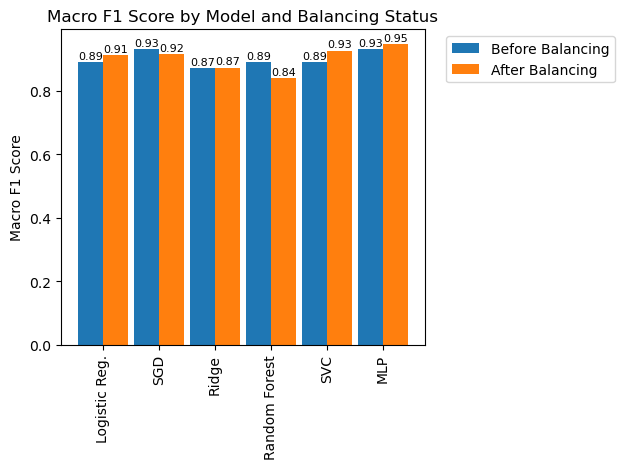

In [76]:
plot_comparison(findings_displacement_tuned["macro_f1_scores"], findings_balanced_tuned["macro_f1_scores"], "Macro F1 Score", "Balancing")

**Analysis**: The 3 models Logistic regression, SVC, and MLP showed an increase in the f1 score after balancing. On the other hand SGD and Random Forest showed a drease in the f1 score after balancing the dataset. Moreover, the Ridge classifier's macro f1 score remained constant. Our interpretation of those findings are as follows:

1. **Logistic Regression Model**: The results show that the macro f1 score of this classifier increased from 0.89 before balancing to 0.91 after balancing the dataset. Therefore, the model slightly benefitted from the balanced distribution. This balance gave the model more samples of the minority classes to learn from and consequently provide a better approximation of the decision boundary between classes.

2. **SGD Classifier**: The results show that there was a very slight decrease in the macro f1 score in this model (from 0.93 to 0.92). The decrease indicates that the SGD classifier might have been already robust against the imbalance in the dataset. Oversampling using SMOTE might have introduced noise to the datset or over-generalization leading to a slightly worse model.

3. **Ridge Classifier**:The macro f1 score remained contant when using the ridge classifier. This implies that the ridge classifier is not sensitive to imbalanced datasets. Perhaps its inherent regularization mitigate the imbalance problem.

4. **Random Forest Classifier**: The macro f1 score exhibited a notable decrease from 0.89 to 0.84 after balancing. Several reasons might be behind this decrease. Random forest classifiers are sensitive to class distributions. After balancing the dataset, the model might have become less certain about the majority classes while also not being able to learn the minority classes better causing a poorer performance. Futhermore, there is a possibility that SMOTE might have failed in creating synthetic data that follows the same distribution as the original training set leading to worse models.  

5. **SVC Classifier**: The results show a significant increase in f1 score from 0.89 to 0.93 after balancing. This notable increase shows that the SVC model improved greatly when trained on a balanced dataset. SVM is sentisive to margins between classes, and the added data might have caused the classifier to find a better margin during training.

6. **MLP Classifier**: The results show a slight improvement from 0.93 to 0.95 after balancing. Therefore, this classifier was able to utilize the added data to better its decision boundaries and capture the complexity of the data.

# Third Approach: Occlusions


The following function will be used to add occlusions to a set of points in a specific dataset: We chose to replace the occluded points by NaN to signal that this data does not exist. We chose NaN since the original dataset does not contain any NaN values. Therefore, it would be easier to spot those points and impute them before testing.

In [77]:
def apply_occlusion(data, points_to_occlude):
    occluded_data = data.copy()
    occluded_data[:, points_to_occlude] = np.nan
    return occluded_data

The following function will be used to add noise to a set of points in a specific dataset: We will generate noise by using Guassian distribution, and later add this noise to the specific points that we want to make noisy. The reason behind choosing a Guassian distribution to generate noise is because of its ubiquity in natural phenomena, alignment with the Central Limit Theorem, and mathematical convenience making it a good choice in our case. 

In [78]:
def add_noise(data, points_to_add_noise, noise_level):
    np.random.seed(42)
    noisy_data = data.copy()
    noise = np.random.normal(0, noise_level, noisy_data.shape)
    noisy_data[:, points_to_add_noise] += noise[:, points_to_add_noise]
    return noisy_data

Next, we will be defining some functions that will be handy later on.

This function will be used to plot the accuracies and f1-scores of the models in a radar chart:

In [79]:
def plot_radar_chart(accuracies, f1_scores, labels):

    accuracy_values = list(accuracies.values())
    f1_values = list(f1_scores.values())
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    accuracy_values += accuracy_values[:1]
    f1_values += f1_values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], labels)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=12)
    plt.ylim(0, 1)

    ax.plot(angles, accuracy_values, color='red', linewidth=2, linestyle='solid', label='Accuracy')
    ax.fill(angles, accuracy_values, color='red', alpha=0.4)
    ax.plot(angles, f1_values, color='blue', linewidth=2, linestyle='solid', label='F1 Score')
    ax.fill(angles, f1_values, color='blue', alpha=0.4)

    for i, label in enumerate(labels):
        ha = 'right' if angles[i] > np.pi/2 and angles[i] < 3*np.pi/2 else 'left'
        va = 'top' if angles[i] > np.pi else 'bottom'
        ax.text(angles[i], accuracy_values[i], f'{accuracy_values[i]:.2f}', ha=ha, va=va, fontsize=9, color='red')
        ax.text(angles[i], f1_values[i], f'{f1_values[i]:.2f}', ha=ha, va=va, fontsize=9, color='blue')
        
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

This function will be used to make predictions and populate dictionaries that will be used to plot some figures.

In [80]:
def predict_and_populate(model, test_X, test_y, dictionary):
    sessions_predictions = model.predict(test_X)
    model_name = type(model).__name__
    accuracy = accuracy_score(test_y, sessions_predictions)
    f1_score_ = f1_score(test_y, sessions_predictions, average='macro')
    dictionary['overall_accuracies'][model_name] = round(accuracy, 2)
    dictionary['macro_f1_scores'][model_name] = round(f1_score_, 2)

This function will be used to perform occlusions add noise, make predictions, then show the results.

In [81]:
def test_on_altered_data_result(points_to_occlude, noise_level, num_points_noise, X_training, X_testing, y_testing, dictionary, trained_models):
    np.random.seed(42)
    occluded_data = apply_occlusion(X_testing, points_to_occlude)
    values = list(set(range(0, 136)) - set(points_to_occlude))
    points_to_add_noise = random.sample(values, num_points_noise)
    noisy_data = add_noise(occluded_data, points_to_add_noise, noise_level)
    
    means = np.mean(X_training, axis=0)
    X_test_filled= np.where(np.isnan(noisy_data), means, noisy_data)

    for model in trained_models:
        predict_and_populate(model, X_test_filled, y_testing, dictionary)
    plot_radar_chart(dictionary["overall_accuracies"], dictionary["macro_f1_scores"], labels)

To test how the models will behave on various occlusion and noise intensities, we will first start by the small occlusions and noises until we cover half of the face and add severe noise:

1. Add occlusion on the eyes with little noise.
2. Add occlusion on the eyes and nose with moderate noise.
3. Add occlusion to the whole left side of the face (left eyebrow, left eye, left cheek, and left half of the lips) with severe noise.

We will study the models' accuracies in the preceeding cases.

## Approach Adopted: Imputation with the Mean

Our approach will be using the previously trained models on occluded data. Since the models cannot predict values with NaN, we will replace the NaN values in the testing set with the mean of the corresponding column in the training set. This approach is straightforward and gives us an idea about how our model will act in real cases where it is trained on clean and complete data but might encounter missing values in the testing set.

## First technique: Using raw coordinates:
First, we will use the models tuned and trained on raw coordinates (i.e., on the last 2 images of sessions in the training set as described in the first part).

In [82]:
findings_raw_mild = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}
findings_raw_moderate = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}
findings_raw_severe = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

### 1. Eyes Occlusion With Little Noise

First, we will apply an occlusion on the eyes, then we will add little perturbation to 5 random points to resemble the noise.

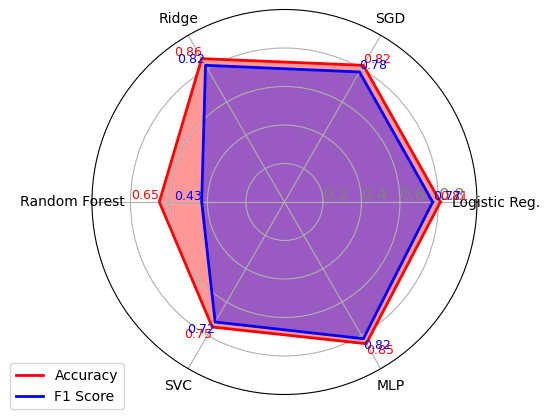

In [83]:
eyes= range(72, 96)

test_on_altered_data_result(eyes, 0.01, 5, X_train_scaled, X_test_scaled, y_test, findings_raw_mild, models_tuned_raw)

**Analysis:** 

1. The results are promising for some models such as Ridge and MLP as they had very good accuracies and f1 scores. The neural network in MLP classifier might have been able to learn complex decision boundaries and was resiltient against noise and occlusions. The ridge classifier had the best accuracy and f1 score suggesting that its linear model did not overfit and was not affected by mild noise and eyes occlusions. Their high f1 scores also show that they had high precision and recall values.
2. However, some other models like Random forest did pretty bad indeed. The low f1 score (0.43) shows that this model is either struggling with precission or recall or even both. The Random Forest classifier is clearly sensitive to changes in features. Indeed, the huge gap between its accuracy and f1 score show that it cannot generalize well for unseen data and is biased to some classes. 

### 2. Eyes and Nose Occlusions With Moderate Noise

Now, we will cover both the eyes and the nose and apply moderate noise to 10 different points.

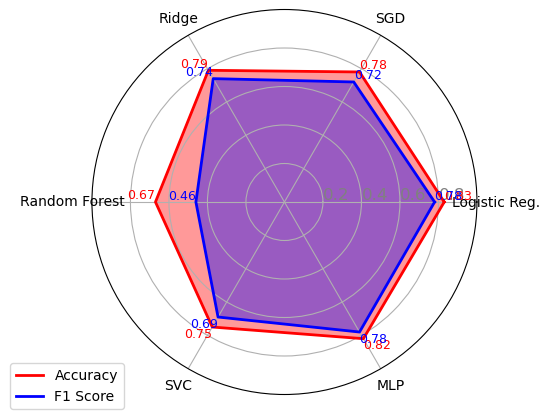

In [84]:
eyes_and_nose = range(54, 96)
test_on_altered_data_result(eyes_and_nose, 0.025, 10, X_train_scaled, X_test_scaled, y_test, findings_raw_moderate, models_tuned_raw)

**Analysis**:

1. The logistic regression as well as MLP classifier did exceptionally well. For the logistic regression model, this might indicate that the model has little reliance on localized features such as the eyes and nose. The MLP classifier continued on performing well. It has a slightly lower accuracy and f1 score than the previous case possibly due to the increased occlusions and noise.
2. The random forest classifier clearly still lags behind the others. This shows that the random forest classifier struggles with occluded and noisy data.

### 3. Cover Half of The Face and Add Severe Noise
Finally, we will cover half of the face and add severe noise to 15 different points.

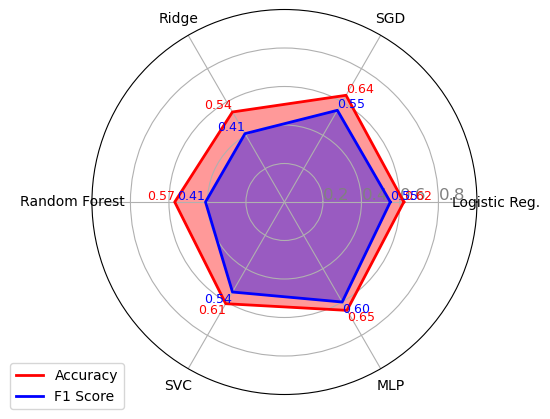

In [85]:
half_face = list(range(0, 18)) + list(range(34, 44)) + list(range(54, 66)) + list(range(72, 84)) + list(range(96, 102)) + list(range(118, 124)) + list(range(116, 118)) + list(range(134, 136))
test_on_altered_data_result(half_face, 0.04, 15, X_train_scaled, X_test_scaled, y_test, findings_raw_severe, models_tuned_raw)

**Analysis:**
1. The results show that all the models trained on raw coordinates do not perform well when we cover half of the face and add extreme noise to the test set.
2. Both the accuracies and f1 scores dropped notably from the last case.
3. This indicates that models trained on raw coordinates are not robust agaist severe alterations in the data and are very prone to making mistakes.

## Second technique: Using Displacement of Points:

Now, we will use the models tuned and trained to the displcament of points between the raw and apex images.

In [86]:
findings_disp_mild = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}
findings_disp_moderate = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}
findings_disp_severe = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

### 1. Eyes Occlusion With Little Noise

First, we will apply an occlusion on the eyes, then we will add little perturbation to 5 random points to resemble the noise.

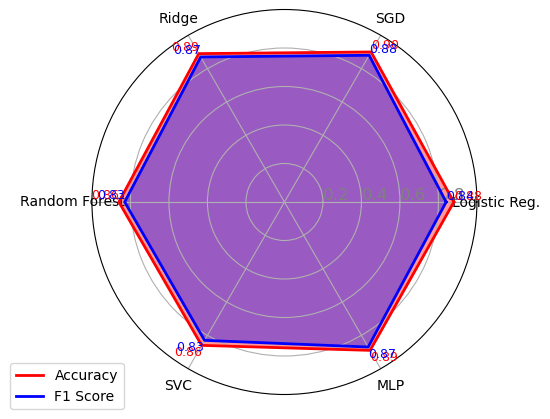

In [87]:
test_on_altered_data_result(eyes, 0.01, 5, X_train_scaled_disp, X_test_scaled_disp, y_test_disp, findings_disp_mild, models_tuned_disp)

**Analysis:**
1. When training the models on the displacement of points between the apex and raw images, the results are impressive for all models when applying eyes occlusions and mild noise to test data.
2. Furthermore, all models have close accuracies and f1 scores indicating balanced performance in all classes and a great generalization.

### 2. Eyes and Nose Occlusions With Moderate Noise
Now, we will cover both the eyes and the nose and apply moderate noise to 10 random points out of the remianing 47 points.

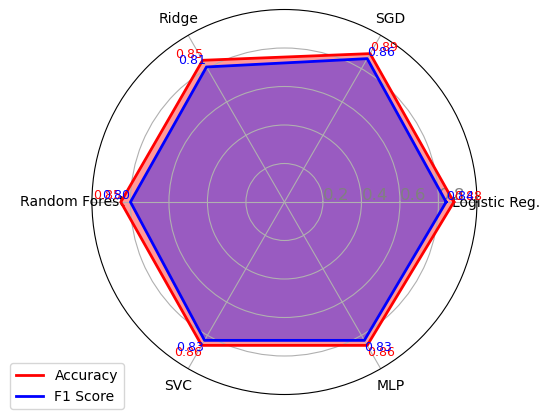

In [88]:
test_on_altered_data_result(eyes_and_nose, 0.025, 10, X_train_scaled_disp, X_test_scaled_disp, y_test_disp, findings_disp_moderate, models_tuned_disp)

**Analysis:**

1. The models continue to perform exceptionally well after covering both the eyes and the nose and adding moderate noise.
2. The accuracies of the different models are still very close to each other indicating similar performance among the models. This indicates that training with points displacement is very effective to acheiving consistent and promising results even with moderate occlusions and noise.

### 3. Cover Half of The Face and Add Severe Noise
Finally, we will cover half of the face and add severe noise to 15 different points.

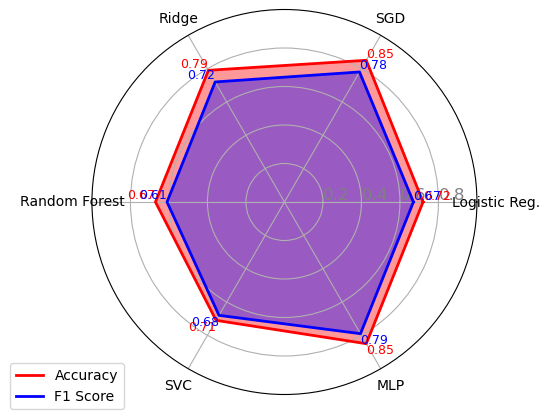

In [89]:
test_on_altered_data_result(half_face, 0.04, 15, X_train_scaled_disp, X_test_scaled_disp, y_test_disp, findings_disp_severe, models_tuned_disp)

**Analysis:**

1. After covering half of the face and adding severe noise, some models such as Random forest and SVC exhibited a big drop in both accuracies and macro f1 scores indicating that those severe alterations pose a challenge to those models.
2. However, some models such as MLP and SGD still performed very well with accuracies equal to 85% and high f1 scores. This indicates that those models are very robust against data aletrations, even in situations where a big part of the face is hidden or distorted.

## Third technique: Using Balanced Dataset:

Finally, we will use the models trained on the dataset balanced with SMOTE.

In [90]:
findings_balanced_mild = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}
findings_balanced_moderate = {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}
findings_balanced_severe= {
    "overall_accuracies": {},
    "macro_f1_scores": {}
}

### 1. Eyes Occlusion With Little Noise

Out of the 56 points remaining after covering the eyes, we will add little perturbation to 5 random points to resemble the noise.

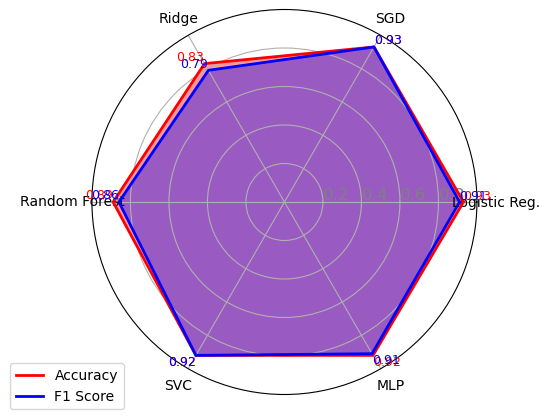

In [91]:
test_on_altered_data_result(eyes, 0.01, 5, X_train_smote, X_test_disp, y_test_disp, findings_balanced_mild, models_tuned_balanced)

**Analysis:**
1. Models such as SGD, MLP, SVC, and Logistic regression exhibited an excellent performance with accuracies and macro f1 scores above 90%. Therefore, these models were able to continue generalizing well even after altering the dataset.
2. On the other hand, the ridge classifier underperformed the other models meaning it struggled a bit with mild alteration in the dataset.

### 2. Eyes and Nose Occlusions With Moderate Noise
Now, we will cover both the eyes and the nose and apply moderate noise to 10 points out of the remianing 47 points.

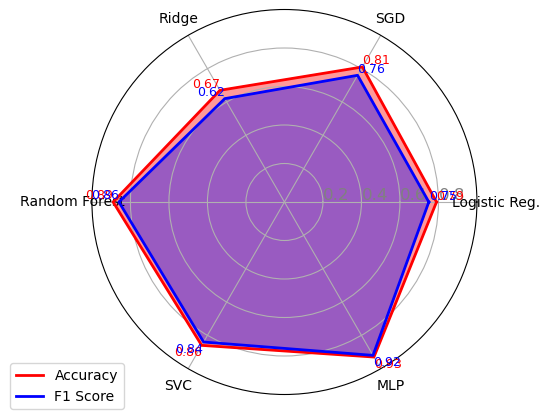

In [92]:
test_on_altered_data_result(eyes_and_nose, 0.025, 10, X_train_smote, X_test_disp, y_test_disp, findings_balanced_moderate, models_tuned_balanced)

**Analysis:**
1. The MLP classifier continued to do exceptionally well even when occluding the eyes and the nose and adding moderate noise. It has a 93% accuracy and an f1 score of 92%.Therefore, this model is very robust against moderate alterations and can accurately predict the emotion even under moderate occlusions and noise.
2. The random forest and SVC models also performed well under those circumstances but the Ridge classifier's ability to predict calsses correctly deteriorated severely. Now, its accuracy is 67% meaning it is very sensitive to occlusions and noise.

### 3. Cover Half of The Face and Add Severe Noise
Finally, we will cover half of the face and add severe noise to 15 different points.

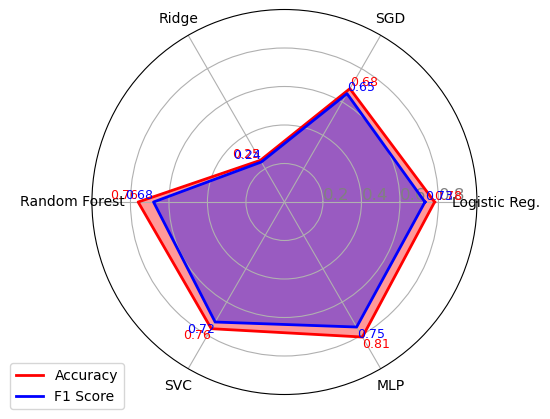

In [93]:
test_on_altered_data_result(half_face, 0.04, 15, X_train_smote, X_test_disp, y_test_disp, findings_balanced_severe, models_tuned_balanced)

**Analysis:**
1. The MLP classifier still has a high accuracy of 81%. It shows the highest resilience, maintaining the best accuracy among all the models. Its performance suggests that it can handle complex patterns and severe modifications in the data effectively.
2. Other models such as SVC, Logistic regressions and random forest also still performed well even with a drop in accuracies and f1 scores after the severe occlusions and noise. 
3. The ridge classifier is the worst among them all (25% accuracy). It struggles a lot under those severe occlusions and is only a very little bit better than a random guesser.

Overall, we can conclude that training models using displacement of points is better than raw coordinates approach as it gave better results overall. The MLP classifier was the most robust model against severe occlusions and noise as it had persistent high accuracies and f1 scores. This might be because of its capability of capturing complex relations among feautures and not overfitting to certain ones which might get occluded. After balancing the dataset, some models became better especially the random forest classifier as it is became more capable of generalizing to useen data even if it was occluded or noisy.